In [1]:
import haversine as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Can a Jockey Increase a Horses Chances?

The goal of this notebook is to provide owners and trainers with more insight into whether a jockey gives their horse a better chance to win. The notebook will start with an analysis of how money rankings of a jockey can be misleading as a measure for jockey performance.  Then the notebook will analyze NYRA horse position data from 2019 and compare the average winning jockey path and pace to each jockeys path and pace.  Using a machine learning technique called clustering, we will demonstarte how a jockeys in-race decisions can increase a horse's chance of winning. Finally, this notebook will introduce three novel jockey statistics to provide quick ranking method to compare jockey performance to other jockeys, relative to the quaility of horses they ride. 

**How Do Owners and Trainers Select Jockeys for Their Horses?**

> A jockey is booked to ride a horse by his agent. The booking requires the agreement of the owner and trainer of the racehorse. The jockey is not the sole decision-maker over which horse he rides. However, good jockeys are sought after and often can pick their horse. [Read More About How Jockeys Choose or are Chosen to Ride a Horse](https://horseracingsense.com/how-do-jockeys-choose-which-horses-they-ride/)

This sounds simple enough - if you own/train racehorses, simply seek out the "best" jockey.  But is it really that easy? Probably not, because we think that measuring jockey performance is not fully understood. Specifically, our thesis is that jockey earnings are not a good measure of whether a jockey increases or decreases a horses chance to win.

***Introduction to Current Jockey Ranking Methods***

When researching online for jockey perfomance data, it is quickly evident that the horse racing community puts a lot of emphasis on jockey money earnings. For example, at the end of each year, the Eclipse Award for Outstanding Jockey is an American thoroughbred horse racing honor for jockeys first awarded in 1971.  Every year since 2000, either the top money winning jockey or the second highest money winning jockey have won the Eclipse award. [List of Eclipse Award Winners](https://en.wikipedia.org/wiki/Eclipse_Award_for_Outstanding_Jockey) A full list of jockeys ranked by earnings for each year from 2000 to 2021 can be viewed [here](https://www.equibase.com/stats/View.cfm?tf=year&tb=jockey).

***2019 "Leading Jockeys"***

For our purposes, the data for the competition is from 2019, so below, is a list of 2019 "Leading Jockeys" ordered by earnings. A full list can be viewed [here](https://www.equibase.com/stats/View.cfm?tf=year&tb=jockey). If you review the full list, you will notice some of the jockeys are not on the list above.  This is because we limited our list to jockeys that had more than 100 starts at NYRA tracks in 2019.

In [2]:
jockey_earnings_df = pd.read_csv('./data/jockey_earnings_2019.tsv', sep='\t')

jockey_earnings_df['Jockey Name'] = jockey_earnings_df['Jockey Name'].str.replace(',', '')
jockey_earnings_df['Total $'] = jockey_earnings_df['Total $'].astype(str)

len(jockey_earnings_df)

100

In [3]:
jockey_earnings_df.head(5)

,Rank,Jockey Name,Starts,1st,2nd,3rd,Total $,Per Start $,Win %,Top 3,Top 3 %
0,1,Irad Ortiz Jr.,"1,516",324,311,221,"$34,109,019","$22,499",21%,856,56%
1,2,Jose L. Ortiz,"1,419",274,246,205,"$27,529,006","$19,400",19%,725,51%
2,3,Javier Castellano,941,197,165,130,"$25,053,713","$26,625",21%,492,52%
3,4,Joel Rosario,"1,104",222,183,183,"$24,913,212","$22,566",20%,588,53%
4,5,Flavien Prat,739,167,143,124,"$19,693,267","$26,649",23%,434,59%


In [4]:
START_TABLE_COLUMNS = [
    'track_id',
    'race_date',
    'race_number',
    'program_number',
    'weight_carried',
    'jockey',
    'odds',
    'position_at_finish'
]

start_df = pd.read_csv('./data/nyra_start_table.csv', names=START_TABLE_COLUMNS)

start_df['odds'] = start_df['odds'].astype(int)

len(start_df)

14915

In [5]:
start_df.head(5)

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1


In [6]:
track_race_date_df = (
    start_df.groupby(['track_id', 'race_date', 'race_number']).size().reset_index().rename(columns={0: 'horses (count)'})
)
len(track_race_date_df)

2000

In [7]:
track_race_date_df.head(5)

,track_id,race_date,race_number,horses (count)
0,AQU,2019-01-01,1,5
1,AQU,2019-01-01,2,7
2,AQU,2019-01-01,3,8
3,AQU,2019-01-01,4,6
4,AQU,2019-01-01,5,7


In [8]:
rankings = []

for i in tqdm(range(len(track_race_date_df))):
    row = track_race_date_df.iloc[i]
    
    race_df = start_df[
        (start_df['track_id'] == row['track_id']) &
        (start_df['race_date'] == row['race_date']) &
        (start_df['race_number'] == row['race_number'])
    ].copy()
    
    # Rank the odds from lowest to highest.
    race_df['odds (rank)'] = race_df['odds'].rank(ascending=True).astype(int)
    rankings.append(race_df)
    
rankings_df = pd.concat(rankings)
len(rankings_df)

  0%|          | 0/2000 [00:00<?, ?it/s]

14915

In [9]:
rankings_df.head(5)

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,odds (rank)
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,1
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,3
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,2
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,5
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,4


In [10]:
len(start_df)

14915

In [11]:
start_df = start_df.merge(
    pd.concat(rankings)[['track_id', 'race_date', 'race_number', 'program_number', 'odds (rank)']], 
    on=['track_id', 'race_date', 'race_number', 'program_number'], 
    how='left'
)
len(start_df)

14915

In [12]:
start_df['plus_minus'] = start_df['odds (rank)'] - start_df['position_at_finish']

In [13]:
start_df.head(5)

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,odds (rank),plus_minus
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,1,-1
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,3,0
2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,2,-2
3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,5,0
4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,4,3


The more positive the plus_minus feature the better.

Remove the non-NYRA jockeys from the earnings list.

In [14]:
jockey_earnings_df = jockey_earnings_df[
    jockey_earnings_df['Jockey Name'].isin(start_df['jockey'].unique())
]
len(jockey_earnings_df)

53

In [15]:
jockey_earnings_df

,Rank,Jockey Name,Starts,1st,2nd,3rd,Total $,Per Start $,Win %,Top 3,Top 3 %
0,1,Irad Ortiz Jr.,"1,516",324,311,221,"$34,109,019","$22,499",21%,856,56%
1,2,Jose L. Ortiz,"1,419",274,246,205,"$27,529,006","$19,400",19%,725,51%
2,3,Javier Castellano,941,197,165,130,"$25,053,713","$26,625",21%,492,52%
3,4,Joel Rosario,"1,104",222,183,183,"$24,913,212","$22,566",20%,588,53%
4,5,Flavien Prat,739,167,143,124,"$19,693,267","$26,649",23%,434,59%
5,6,John R. Velazquez,777,141,123,110,"$18,795,157","$24,189",18%,374,48%
6,7,Luis Saez,"1,428",274,207,177,"$18,209,050","$12,751",19%,658,46%
7,8,Ricardo Santana Jr.,"1,103",190,157,145,"$16,721,338","$15,160",17%,492,45%
8,9,Manuel Franco,"1,340",221,223,203,"$16,688,680","$12,454",16%,647,48%
9,10,Tyler Gaffalione,"1,217",185,184,178,"$15,191,766","$12,483",15%,547,45%


**Are Earnings a Good Measure of Jockey Performance?**

The short answer is no and here is why.

Think about the beginning of a new racing season, if the owners and trainers of the best horses seek out the "top" jockeys from the prior years money earnings list, it will become a self fulfilling prophecy that the top money winning jockeys from last year get to ride the best horses to start the new season.  As the new season progresses, the top money winners from last year are getting better opportunities in the new season, they should start out winning more than most jockeys and ascend to the top of the money list, and this perpetuates that they are the best jockeys.  We think that this phenomenon may also account for the many repeat, back to back winners of the Eclipse awards.

To better understand the quaility of horses each jockey rode, let's look at the average odds per race that the 2019 "top" jockeys who raced more than 100 races at NYRA tracks. The average odds of the horses ridden gives us insight to the quaility of horses that the jockey rode compared to the other jockeys.

In [16]:
jockeys_by_mounts_df = start_df.groupby('jockey').agg({'track_id': 'count'}).reset_index()
jockeys_by_mounts_df.columns = ['jockey', 'mounts']

jockeys_by_mounts_df.sort_values('mounts', ascending=False)

,jockey,mounts
119,Manuel Franco,1274
42,Dylan Davis,1108
96,Jose Lezcano,990
103,Junior Alvarado,852
66,Irad Ortiz Jr.,802
...,...,...
35,Dana G. Whitney,1
97,Jose R. Betancourt,1
28,Christophe Soumillon,1
25,Charlie Amaro,1


In [17]:
jockeys_by_mounts_df = jockeys_by_mounts_df[jockeys_by_mounts_df['mounts'] >= 500].sort_values('mounts', ascending=False)
jockeys_by_mounts_df

,jockey,mounts
119,Manuel Franco,1274
42,Dylan Davis,1108
96,Jose Lezcano,990
103,Junior Alvarado,852
66,Irad Ortiz Jr.,802
50,Eric Cancel,721
106,Kendrick Carmouche,714
95,Jose L. Ortiz,702
118,Luis Saez,666
77,Joel Rosario,657


Text(0.5, 1.0, 'Average Odds of Horses Ridden NYRA Tracks')

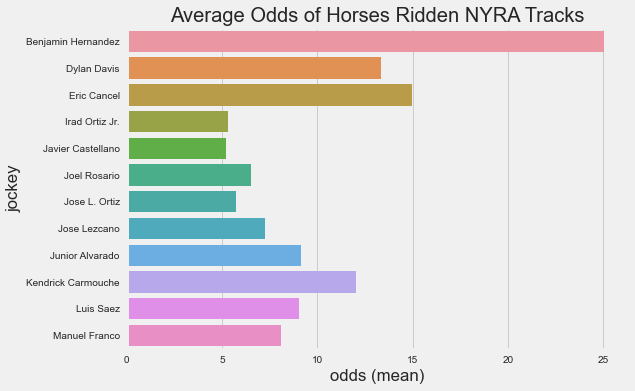

In [18]:
grouped_df = start_df.groupby('jockey').agg({'odds': 'mean'}).reset_index()
grouped_df.columns = ['jockey', 'odds (mean)']

grouped_df = grouped_df[grouped_df['jockey'].isin(jockeys_by_mounts_df['jockey'])]
grouped_df['odds (mean)'] = grouped_df['odds (mean)'] / 100.0

jockey_earnings_df['Total $'] = jockey_earnings_df['Total $'].astype(str)
jockey_earnings_df['Total $'] = jockey_earnings_df['Total $'].str.replace('$', '')
jockey_earnings_df['Total $'] = jockey_earnings_df['Total $'].str.replace(',', '').astype('double')

grouped_df = grouped_df.merge(jockey_earnings_df, left_on=['jockey'], right_on=['Jockey Name'], how='left')

sns.barplot(data=grouped_df, x='odds (mean)', y='jockey')
plt.title('Average Odds of Horses Ridden NYRA Tracks')

Text(0.5, 1.0, 'Earnings (Tens of Millions)')

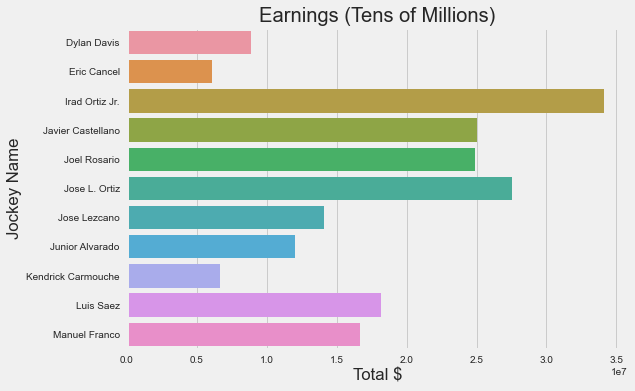

In [19]:
sns.barplot(
    data=grouped_df, 
    x='Total $', 
    y='Jockey Name'
)

plt.title('Earnings (Tens of Millions)')

In [20]:
grouped_df[['odds (mean)', 'Total $']].corr()

,odds (mean),Total $
odds (mean),1.000000,-0.884467
Total $,-0.884467,1.000000


As you can see by the graphs above, the higher money winning jockeys ride the lower odds horses which should equate to a better quaility horse and higher finishes and more prize money / earnings.  And with the exception of Tyler Gaffalione and Ricardo Santana Jr., the horse odds mostly increase while the money won decreases - not a perfect relationship, but you can see a pattern. So we think that because top money winning jockeys get the better horses to ride, they should win more races and earn more money, which can skew the reliability of money earnings as measure of jockey performance.

So, now the question is how do we determine which jockey gives a horse a better chance to win?

**How to Measure a Jockey's Contribution to Increasing a Horses Chance to Win**

Simple - owners and trainers should simply pick jockeys that, on average, ride the optimal path and pace for the same track, surface and distance their horse is racing. But what is the optimal path and pace?

Our thesis is that the optimal path and pace is the average path and pace for all the winning horses that have won on that track, surface and distance.  The average is derived by taking every winning horse and averaging their position on the track at each trakus_index.

Then we can simply average every jockey's average position who raced the same track, course and distance and compare them to the optimal winning path and pace.  We would then select the jockeys who rank, on average, closest to the optimal winning path and pace.  We will explain the process more in detail below.

For the purposes of this analysis, we will use Aqueduct 6 furlongs on dirt because there were 219 races run in 2019 and this will provide plenty of data for our analysis purposes.

In [21]:
COMPLETE_COLUMNS = [
    'track_id',
    'race_date',
    'race_number',
    'program_number',
    'trakus_index',
    'latitude',
    'longitude',
    'distance_id',
    'course_type',
    'track_condition',
    'run_updistance',
    'race_type',
    'purse',
    'post_time',
    'weight_carried',
    'jockey',
    'odds',
    'position_at_finish'
]

complete_df = pd.read_csv('./data/nyra_2019_complete.csv', names=COMPLETE_COLUMNS)
len(complete_df)

5228430

In [22]:
complete_df.head(5).T

,0,1,2,3,4
track_id,AQU,AQU,AQU,AQU,AQU
race_date,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
race_number,9,9,9,9,9
program_number,6,6,6,6,6
trakus_index,72,73,74,63,64
latitude,40.672902,40.672946,40.67299,40.67251,40.672553
longitude,-73.827607,-73.827587,-73.827568,-73.827781,-73.827762
distance_id,600,600,600,600,600
course_type,D,D,D,D,D
track_condition,GD,GD,GD,GD,GD


Let's look at 6F dirt races at AQU.

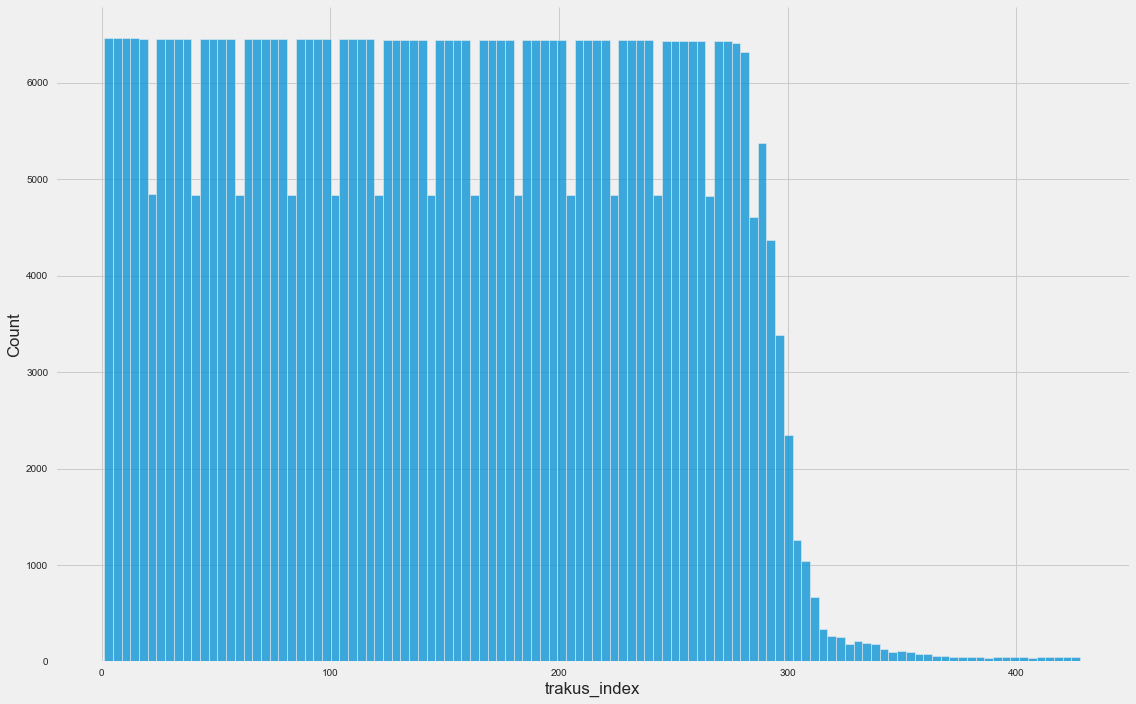

In [23]:
sns.displot(
    data=complete_df[
            (complete_df['track_id'] == 'AQU') & 
            (complete_df['distance_id'] == 600) & 
            (complete_df['course_type'] == 'D')
    ], 
    x='trakus_index',
    height=10, aspect=1.6
)

In [24]:
complete_df[
    (complete_df['track_id'] == 'AQU') & 
    (complete_df['distance_id'] == 600) & 
    (complete_df['course_type'] == 'D')
]['trakus_index'].describe()

count    481916.000000
mean        150.401508
std          87.226649
min           1.000000
25%          75.000000
50%         150.000000
75%         225.000000
max         428.000000
Name: trakus_index, dtype: float64

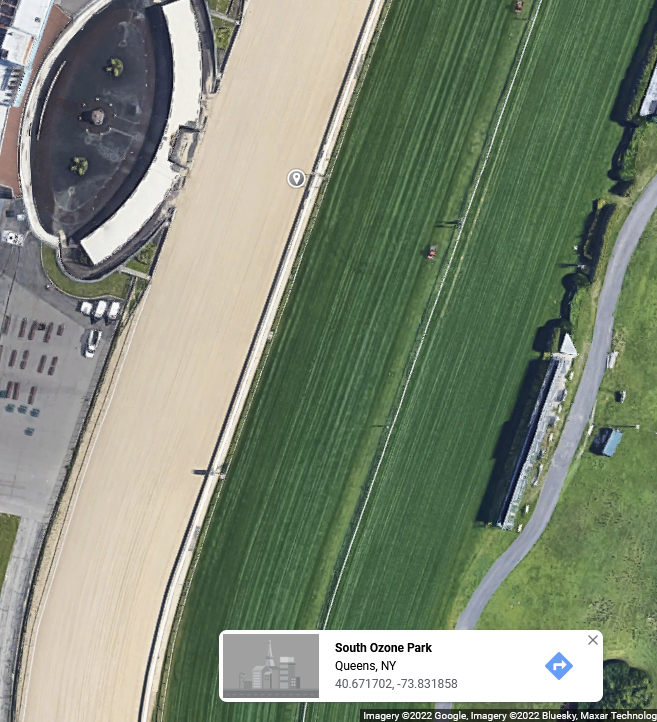

There might be some outliers in the data collected.

The finish line for the dirt track looks to be located approximately at (40.67102, -73.831858).  Let's find out what trakus_index correlates closest to these spots.

NOTE:  haversine distance is reported in KM.

In [25]:
aqu_6f_df = complete_df[
    (complete_df['track_id'] == 'AQU') & 
    (complete_df['distance_id'] == 600) & 
    (complete_df['course_type'] == 'D')
].copy()


AQU_DIRT_FINISH = (40.671702, -73.831858)

aqu_6f_df['dist_to_finish'] = aqu_6f_df.apply(
    lambda row: hs.haversine(AQU_DIRT_FINISH, (row['latitude'], row['longitude'])),
    axis=1
)

aqu_6f_df.head(5).T

,0,1,2,3,4
track_id,AQU,AQU,AQU,AQU,AQU
race_date,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
race_number,9,9,9,9,9
program_number,6,6,6,6,6
trakus_index,72,73,74,63,64
latitude,40.672902,40.672946,40.67299,40.67251,40.672553
longitude,-73.827607,-73.827587,-73.827568,-73.827781,-73.827762
distance_id,600,600,600,600,600
course_type,D,D,D,D,D
track_condition,GD,GD,GD,GD,GD


What trakus_index values is dist_to_finish minimized?

In [26]:
aqu_6f_df.groupby('trakus_index').agg({ 'dist_to_finish': 'mean'}).reset_index().sort_values('dist_to_finish').head(5)

,trakus_index,dist_to_finish
265,266,0.023256
264,265,0.023340
266,267,0.023624
263,264,0.023901
267,268,0.024420


It looks like '265' is the closest data point to the finish line.

What about the starting gate?

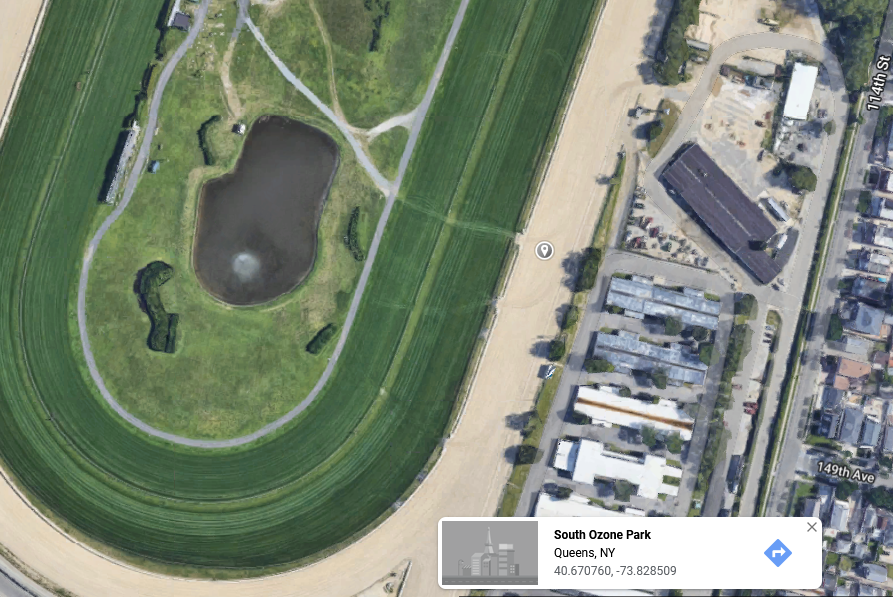

In [27]:
AQU_6F_DIRT_START = (40.670760, -73.828509)

In [28]:
aqu_6f_df['dist_to_start'] = aqu_6f_df.apply(
    lambda row: hs.haversine(AQU_6F_DIRT_START, (row['latitude'], row['longitude'])),
    axis=1
)

In [29]:
aqu_6f_df.groupby('trakus_index').agg({ 'dist_to_start': 'mean'}).reset_index().sort_values('dist_to_start').head(5)

,trakus_index,dist_to_start
20,21,0.010234
19,20,0.010295
21,22,0.010908
18,19,0.011359
22,23,0.012680


So we are interested in all trakus_index data points between 21 and 265 which represents that actual race.

Collect the trips taken by all of the winners and the top jockeys.

In [30]:
winners_aqu_600D_df = aqu_6f_df[
    (aqu_6f_df['position_at_finish'] == 1)
]
len(winners_aqu_600D_df)

65604

In [31]:
jockeys_by_mounts_df['jockey']

119         Manuel Franco
42            Dylan Davis
96           Jose Lezcano
103       Junior Alvarado
66         Irad Ortiz Jr.
50            Eric Cancel
106    Kendrick Carmouche
95          Jose L. Ortiz
118             Luis Saez
77           Joel Rosario
18     Benjamin Hernandez
71      Javier Castellano
Name: jockey, dtype: object

In [34]:
def average_lat_lng(name, df):
    grouped_df = df.groupby('trakus_index').agg({ 'latitude': 'mean', 'longitude': 'mean'}).reset_index()
 
    # Discard data before the start of the race and after the horse crosses the finish line and slows down.
    grouped_df = grouped_df[
        (grouped_df['trakus_index'] >= 21) &
        (grouped_df['trakus_index'] <= 265)
    ]
    
    # Flatten the data into one row by jockey.
    row_df = {
        'jockey': name
    }
    
    for _, row in grouped_df.iterrows():
        row_df['trk_lat{:}'.format(int(row['trakus_index']))] = row['latitude']
        row_df['trk_lon{:}'.format(int(row['trakus_index']))] = row['longitude']
        
    return row_df

In [35]:
cluster_df = []

# Add all of the winning trips.
cluster_df.append(average_lat_lng('average_winners', aqu_6f_df[aqu_6f_df['position_at_finish'] == 1]))

# Add all of the top jockey trips.
for jockey in jockeys_by_mounts_df['jockey']:
    cluster_df.append(average_lat_lng(jockey, aqu_6f_df[aqu_6f_df['jockey'] == jockey]))
    
cluster_df = pd.DataFrame(cluster_df)
cluster_df

,jockey,trk_lat21,trk_lon21,trk_lat22,trk_lon22,trk_lat23,trk_lon23,trk_lat24,trk_lon24,trk_lat25,...,trk_lat261,trk_lon261,trk_lat262,trk_lon262,trk_lat263,trk_lon263,trk_lat264,trk_lon264,trk_lat265,trk_lon265
0,average_winners,40.670787,-73.828534,40.670827,-73.828517,40.670867,-73.828500,40.670907,-73.828483,40.670949,...,40.671725,-73.831868,40.671689,-73.831884,40.671653,-73.831901,40.671617,-73.831917,40.671582,-73.831933
1,Manuel Franco,40.670781,-73.828541,40.670820,-73.828524,40.670860,-73.828507,40.670901,-73.828490,40.670942,...,40.671860,-73.831810,40.671825,-73.831826,40.671790,-73.831841,40.671756,-73.831857,40.671721,-73.831872
2,Dylan Davis,40.670779,-73.828543,40.670818,-73.828527,40.670857,-73.828510,40.670897,-73.828493,40.670938,...,40.671838,-73.831819,40.671803,-73.831835,40.671768,-73.831851,40.671733,-73.831867,40.671698,-73.831883
3,Jose Lezcano,40.670783,-73.828542,40.670822,-73.828526,40.670863,-73.828509,40.670903,-73.828492,40.670945,...,40.671788,-73.831847,40.671753,-73.831863,40.671718,-73.831879,40.671683,-73.831895,40.671648,-73.831911
4,Junior Alvarado,40.670772,-73.828540,40.670811,-73.828523,40.670854,-73.828505,40.670895,-73.828488,40.670936,...,40.671849,-73.831829,40.671814,-73.831844,40.671780,-73.831860,40.671746,-73.831875,40.671711,-73.831891
5,Irad Ortiz Jr.,40.670799,-73.828541,40.670839,-73.828524,40.670879,-73.828507,40.670920,-73.828489,40.670962,...,40.671867,-73.831808,40.671833,-73.831823,40.671799,-73.831839,40.671765,-73.831854,40.671732,-73.831870
6,Eric Cancel,40.670773,-73.828532,40.670812,-73.828515,40.670851,-73.828499,40.670890,-73.828482,40.670930,...,40.671881,-73.831817,40.671846,-73.831833,40.671811,-73.831849,40.671776,-73.831865,40.671741,-73.831881
7,Kendrick Carmouche,40.670775,-73.828534,40.670815,-73.828517,40.670855,-73.828500,40.670896,-73.828483,40.670937,...,40.671827,-73.831828,40.671792,-73.831844,40.671756,-73.831860,40.671721,-73.831876,40.671687,-73.831892
8,Jose L. Ortiz,40.670800,-73.828543,40.670840,-73.828526,40.670880,-73.828509,40.670921,-73.828491,40.670963,...,40.671772,-73.831853,40.671738,-73.831869,40.671705,-73.831884,40.671671,-73.831899,40.671638,-73.831914
9,Luis Saez,40.670812,-73.828517,40.670853,-73.828500,40.670894,-73.828482,40.670935,-73.828465,40.670977,...,40.671672,-73.831893,40.671637,-73.831909,40.671602,-73.831925,40.671567,-73.831942,40.671532,-73.831958


**Visualizing a Jockey's Average Path and Pace Compared to the Optimal Average Path and Pace**

So with the average path and pace data organized, the goal is to visulize how the jockeys path and pace relate to the average winning path and pace.  To help us visualize we will use a machine learning technique called K-Means clustering. K-means clustering is a form of unsupervised learning. It is in situtaions like this with loads of unlabeled data (any info without defined groups or categories.) K-means clustering's goal is to search for data for various groups. If you would like more detail about K-means clustering [click here](http://https://datascience.eu/machine-learning/k-means-clustering-in-machine-learning)

However, because the data has so many columns, what data scientists call dimensions, the data has to be "shrunk down" before we can feed to it to the K-means clustering algorithm.  To assist with the data shrinking the data, a machine learning algortihm called primary component analysis (PCA).

Specifically, PCA is a statistical procedure that converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components . In simpler words, PCA is often used to simplify data, reduce noise, and find unmeasured “latent variables”. If you would like more detail about PCA [click here](http://https://builtin.com/data-science/step-step-explanation-principal-component-analysis).

For our purposes, PCA was used to reduce the data from 482 dimensions down to 6.  The 6 columns of data were then fed to the K-means clustering algorithm which produced the cluster graph below showing how all jockeys average path and pace relate to the average winning path and pace.


In [36]:
X = cluster_df[[c for c in cluster_df.columns if c != 'jockey']]

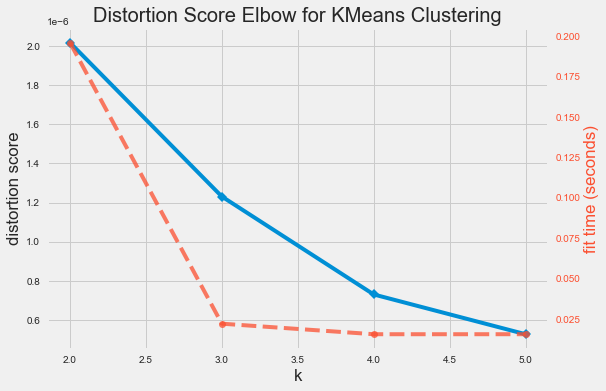

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
model = KMeans(random_state=0)

visualizer = KElbowVisualizer(model, k=(2,6), timings=True)
visualizer.fit(X)

visualizer.show()

In [39]:
n_clusters=3

In [40]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter= 500, n_init= 10, random_state=0)
clusters = kmeans.fit_predict(X)
clusters

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0])

In [41]:
cluster_df['cluster'] = clusters
cluster_df

,jockey,trk_lat21,trk_lon21,trk_lat22,trk_lon22,trk_lat23,trk_lon23,trk_lat24,trk_lon24,trk_lat25,...,trk_lon261,trk_lat262,trk_lon262,trk_lat263,trk_lon263,trk_lat264,trk_lon264,trk_lat265,trk_lon265,cluster
0,average_winners,40.670787,-73.828534,40.670827,-73.828517,40.670867,-73.828500,40.670907,-73.828483,40.670949,...,-73.831868,40.671689,-73.831884,40.671653,-73.831901,40.671617,-73.831917,40.671582,-73.831933,0
1,Manuel Franco,40.670781,-73.828541,40.670820,-73.828524,40.670860,-73.828507,40.670901,-73.828490,40.670942,...,-73.831810,40.671825,-73.831826,40.671790,-73.831841,40.671756,-73.831857,40.671721,-73.831872,1
2,Dylan Davis,40.670779,-73.828543,40.670818,-73.828527,40.670857,-73.828510,40.670897,-73.828493,40.670938,...,-73.831819,40.671803,-73.831835,40.671768,-73.831851,40.671733,-73.831867,40.671698,-73.831883,1
3,Jose Lezcano,40.670783,-73.828542,40.670822,-73.828526,40.670863,-73.828509,40.670903,-73.828492,40.670945,...,-73.831847,40.671753,-73.831863,40.671718,-73.831879,40.671683,-73.831895,40.671648,-73.831911,0
4,Junior Alvarado,40.670772,-73.828540,40.670811,-73.828523,40.670854,-73.828505,40.670895,-73.828488,40.670936,...,-73.831829,40.671814,-73.831844,40.671780,-73.831860,40.671746,-73.831875,40.671711,-73.831891,1
5,Irad Ortiz Jr.,40.670799,-73.828541,40.670839,-73.828524,40.670879,-73.828507,40.670920,-73.828489,40.670962,...,-73.831808,40.671833,-73.831823,40.671799,-73.831839,40.671765,-73.831854,40.671732,-73.831870,1
6,Eric Cancel,40.670773,-73.828532,40.670812,-73.828515,40.670851,-73.828499,40.670890,-73.828482,40.670930,...,-73.831817,40.671846,-73.831833,40.671811,-73.831849,40.671776,-73.831865,40.671741,-73.831881,1
7,Kendrick Carmouche,40.670775,-73.828534,40.670815,-73.828517,40.670855,-73.828500,40.670896,-73.828483,40.670937,...,-73.831828,40.671792,-73.831844,40.671756,-73.831860,40.671721,-73.831876,40.671687,-73.831892,0
8,Jose L. Ortiz,40.670800,-73.828543,40.670840,-73.828526,40.670880,-73.828509,40.670921,-73.828491,40.670963,...,-73.831853,40.671738,-73.831869,40.671705,-73.831884,40.671671,-73.831899,40.671638,-73.831914,0
9,Luis Saez,40.670812,-73.828517,40.670853,-73.828500,40.670894,-73.828482,40.670935,-73.828465,40.670977,...,-73.831893,40.671637,-73.831909,40.671602,-73.831925,40.671567,-73.831942,40.671532,-73.831958,2


In [42]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

cluster_df['pca_2d (x)'] = [x for (x,y) in pca_2d]
cluster_df['pca_2d (y)'] = [y for (x,y) in pca_2d]

Text(0.5, 1.0, 'AQU 6F Dirt - Average Pace Path 2019')

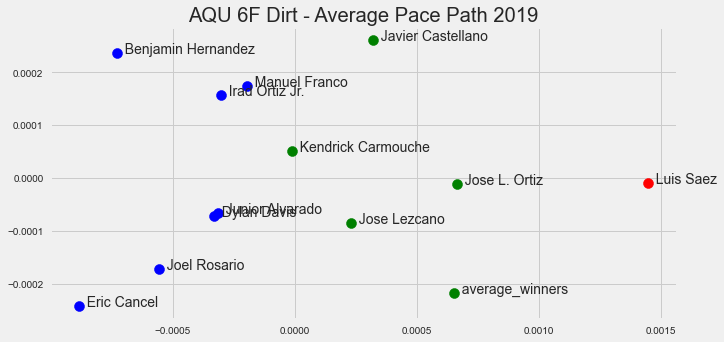

In [43]:
plt.figure(figsize=(10,5))

colors = ['green', 'blue', 'red', 'yellow']

for i in range(n_clusters):
    plt.scatter(
        cluster_df[cluster_df['cluster'] == i]['pca_2d (x)'], 
        cluster_df[cluster_df['cluster'] == i]['pca_2d (y)'], 
        s=100, 
        c=colors[i]
    )

for _, row in cluster_df.iterrows():
    plt.annotate('  ' + row['jockey'], (row['pca_2d (x)'], row['pca_2d (y)']))
    
plt.title('AQU 6F Dirt - Average Pace Path 2019')

Per this analysis, Lezcano, JL Ortiz, Castellano, and Carmouche were better jockeys at AQU in 2019 at 6F than their earnings would represent.

What about the trakus_index data points before the race (warmup)...Can that data be analyzed to see if one jockey handles their horses better than their peers?